In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

## Narrow breath hold length

## Load Files Function

In [9]:
def filelist(root):
    '''
    Return a fully-qualified list of filenames under root directory; 
    sort names alphabetically.
    '''
    allfiles = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            allfiles.append(os.path.join(path, name))
    return sorted(allfiles)

## Process Files (Helper Functions)

In [10]:
def longest_true_seq(bool_curve):
    '''
    Given an array of booleans,
    return indices of longest streak
    of Trues
    '''
    longest_streak = 0
    longest_streak_idx = []

    idx = [] 
    streak = 0
    for i in range(len(bool_curve)):
        if bool_curve[i] == True:
            streak += 1
            idx.append(i)
        else:
            if streak > longest_streak:
                longest_streak = streak
                longest_streak_idx = idx     
            streak = 0
            idx = []
    if streak > longest_streak and longest_streak < 150: # Not sure what this val should be
        return [0]
    return longest_streak_idx

In [11]:
def add_zeros(curve, bh_start_idx, bh_end_idx):
    ''' 
    Return trace with zeros appended to beginning 
    so length of input trace is 1500
    '''
    front_of_curve = curve[:bh_start_idx]
    num_zeros = 1400 - len(front_of_curve)
    zeros = np.zeros([1, num_zeros])[0]
    return np.concatenate((zeros, curve[:bh_end_idx]))

In [12]:
def process_curve(curve):
    '''
    Extract input trace from entire trace
    '''
    deriv = np.diff(curve)
    breath_hold_idx = longest_true_seq(abs(deriv)<=0.001) # Not sure what this val should be
    bh_start_idx = breath_hold_idx[0]
    
    if len(breath_hold_idx) < 100:
         return [], 0, 0

    bh_end_idx = breath_hold_idx[99] + 1
    if bh_start_idx < 1400:
        return add_zeros(curve, bh_start_idx, bh_end_idx), len(breath_hold_idx)*.01, breath_hold_idx
    
    else:
        curve_start_idx = bh_start_idx - 1400
        return curve[curve_start_idx:bh_end_idx], len(breath_hold_idx)*.01, breath_hold_idx
    

## Create DF of Inputs and Outputs

In [13]:
def get_inputs_outputs_df(file_root):
    '''
    Given a root with files, get a dataframe of shape (5680, 2)
    with input data traces (arrays) and 
    output data breath_holds (floats) 
    '''
    filenames = filelist(file_root)
    
    orig_curves = []
    csv_breath_holds = []
    traces = []
    data_breath_holds = []
    bh_idxs = []
    bh_start_end = []
    
    for file in filenames:
        if file.endswith('.CSV'):     
            df = pd.read_csv(file, header=None)
            curve = np.array(df.iloc[3:, 0], dtype='float32')
            input_trace, bh_len, bh_idx = process_curve(curve)
            if len(input_trace) != 0:
                orig_curves.append(curve)
                traces.append(input_trace)
                csv_breath_holds.append(float(df.iloc[1,1]))
                data_breath_holds.append(bh_len)
                bh_idxs.append(bh_idx)
                bh_start_end.append((bh_idx[0], bh_idx[-1]))
    
    data = {'Trace': traces,'Csv_breath_holds': csv_breath_holds, 'Data_breath_holds': data_breath_holds, 
            'Full_trace': orig_curves, "breathhold_idx": bh_idxs, 'bh_start_end':bh_start_end}
    return pd.DataFrame(data)

In [14]:
breath_df = get_inputs_outputs_df('data_sdx_')

In [15]:
breath_df.head()

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.1319, 0.1363, 0.1408, 0.1452, 0.1497, 0.154...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"
1,"[0.4727, 0.4687, 0.4646, 0.4605, 0.4563, 0.452...",30.61,31.40,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386, 2387, 2388, 2389, 2390, 2391, 2392, 239...","(2386, 5525)"
2,"[0.6466, 0.6496, 0.6526, 0.6555, 0.6583, 0.661...",14.39,18.43,"[0.0002, 0.0005, 0.0008, 0.0012, 0.0016, 0.002...","[2118, 2119, 2120, 2121, 2122, 2123, 2124, 212...","(2118, 3960)"
3,"[0.0982, 0.0966, 0.095, 0.0934, 0.0919, 0.0904...",30.85,31.84,"[0.0013, 0.0027, 0.0034, 0.0041, 0.005, 0.006,...","[2573, 2574, 2575, 2576, 2577, 2578, 2579, 258...","(2573, 5756)"
4,"[0.0117, 0.0109, 0.0102, 0.0095, 0.0089, 0.008...",32.12,32.53,"[0.0012, 0.0015, 0.0019, 0.0023, 0.0029, 0.003...","[2520, 2521, 2522, 2523, 2524, 2525, 2526, 252...","(2520, 5772)"


In [19]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [20]:
under2 = under2[(under2['Data_breath_holds']<=40) & (under2['Data_breath_holds']>=20)]

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
df = under2

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['Data_breath_holds'], test_size=0.2)

In [31]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [32]:
# Change type of each row from np.array to list to put into scaler
x_train = np.array([list(row) for row in x_train])
x_val = np.array([list(row) for row in x_val])
x_test = np.array([list(row) for row in x_test])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [33]:
scaler = StandardScaler() # creates the scaler
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

## Initialize Data for Model

In [34]:
#dataset
from torch.utils.data import Dataset

In [35]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [36]:
dataset = timeseries(x_train,y_train)
valid_dataset = timeseries(x_val,y_val)
test_dataset = timeseries(x_test,y_test)

In [37]:
train_loader = DataLoader(dataset,shuffle=True,batch_size=100)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=100)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=100)

## Define LSTM Model (One Step Prediction)

In [39]:
#neural network
from torch import nn

class LSTM_Model(nn.Module):
    def __init__(self):
        super(LSTM_Model,self).__init__()
        self.lstm = nn.LSTM(input_size=1,hidden_size=100,num_layers=1,batch_first=True) # change hidden size
        self.linear = nn.Linear(in_features=100,out_features=1)
        
        
    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        #output = self.linear(torch.relu(output))
        output = self.linear(output)
        return output

model = LSTM_Model()

In [40]:
# Declaring Criterion and Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)
epochs = 50

## Training Loop

In [41]:
history = []
for i in range(epochs):
    
    train_mse = 0.0
    train_mae = 0.0
    train_loss = 0.0
    train_preds = []
    for x, y in train_loader:
        
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        ypred = model(x.view(-1,1500,1))       
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1))      
        # Calculate gradients
        loss.backward()       
        # Update Weights
        optimizer.step()      
        # Calculate L1 Loss
        train_loss += loss.item()
        # Calculate MAE
        ypred = ypred.detach().numpy()
        train_mae += mean_absolute_error(ypred, y.view(-1,1))
        # Calculate MSE
        train_mse += mean_squared_error(ypred, y.view(-1,1))
        # R^2
        
        train_preds.append(ypred)
        
    valid_mse = 0.0
    valid_mae = 0.0
    valid_loss = 0.0
    val_preds = []
    for x, y in val_loader:
        # Forward Pass
        ypred = model(x.view(-1,1500,1))
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1))
        # Calculate L1 Loss
        valid_loss += loss.item()
        # Calculate MAE
        ypred = ypred.detach().numpy()
        valid_mae += mean_absolute_error(ypred, y.view(-1,1))
        # Calculate MSE
        valid_mse += mean_squared_error(ypred, y.view(-1,1))
        
        val_preds.append(ypred)

    history.append((train_loss/len(train_loader),valid_loss/len(val_loader)))
    if i%2 == 0:
        torch.save(model, 'lstm_single_output')
        print(f'Epoch {i+1} \t Training Loss: {train_loss/len(train_loader)} \tValidation Loss: {valid_loss/len(val_loader)}')
        print(f'\t\t Training MAE: {train_mae/len(train_loader)} \tValidation MAE: {valid_mae/len(val_loader)}')
        print(f'\t\t Training MSE: {train_mse/len(train_loader)} \tValidation MSE: {valid_mse/len(val_loader)}')
        print()
    
    

Epoch 1 	 Training Loss: 157.73849404376486 	Validation Loss: 53.63302103678385
		 Training MAE: 9.676889222601186 	Validation MAE: 6.348289171854655
		 Training MSE: 157.73849785846213 	Validation MSE: 53.633021672566734

Epoch 3 	 Training Loss: 22.866004736527152 	Validation Loss: 22.65471426645915
		 Training MAE: 3.8317153142846148 	Validation MAE: 3.853075464566549
		 Training MSE: 22.866004860919453 	Validation MSE: 22.65471426645915

Epoch 5 	 Training Loss: 22.209305472995926 	Validation Loss: 21.475516001383465
		 Training MAE: 3.7647837866907534 	Validation MAE: 3.7360911766688027
		 Training MSE: 22.20930518274722 	Validation MSE: 21.475516319274902

Epoch 7 	 Training Loss: 22.254683536031973 	Validation Loss: 21.574795087178547
		 Training MAE: 3.775034137394117 	Validation MAE: 3.7404212156931558
		 Training MSE: 22.254684116529383 	Validation MSE: 21.574795722961426

Epoch 9 	 Training Loss: 22.383609688800313 	Validation Loss: 21.730640411376953
		 Training MAE: 3.7897

KeyboardInterrupt: 

## Plot Loss

In [42]:
history = torch.tensor(history)

In [43]:
#torch.save(model, 'lstm_bh_epochs')

In [44]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]

    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, '--', label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"{file}.pdf")

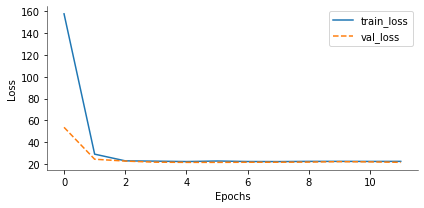

In [45]:
plot_loss(history, maxy = 50)

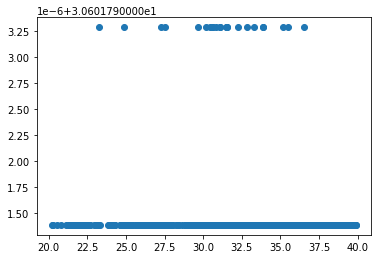

In [46]:
#test set actual vs predicted
test_set = timeseries(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,1500,1)).view(-1)
plt.scatter(test_set[:][1].view(-1), test_pred.detach().numpy(),label='predicted')
plt.show()

In [1]:
test_pred = model(test_set[:][0].view(-1,1500,1)).view(-1)

NameError: name 'model' is not defined

In [2]:
test_set[:][1].view(-1)

NameError: name 'test_set' is not defined

In [ ]:
test_pred